# Reinforcement Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://atenea.upc.edu/course/view.php?id=71605" target="_blank">
      <img src="https://github.com/dmaluenda/deeplearning_course/raw/master/resources/upc_logo_49px.png" width="130"/>
    </a>
  </td>
  <td>
  </td>
  <td>   <!-- gColab -->
    <a href="https://colab.research.google.com/github/dmaluenda/deeplearning_course/blob/master/03_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/deeplearning_course/master/resources/colab_logo_32px.png" />
      Run in Google Colab
    </a>
  </td>
  <td>   <!-- github -->
    <a href="https://github.com/dmaluenda/deeplearning_course/blob/master/03_Reinforcement_Learning.ipynb" target="_blank">
      <img src="https://raw.githubusercontent.com/dmaluenda/deeplearning_course/master/resources/github_logo_32px.png" />
      View source on GitHub
    </a>
  </td>
  <td>   <!-- download -->
    <a href="https://raw.githubusercontent.com/dmaluenda/deeplearning_course/master/03_Reinforcement_Learning.ipynb"  target="_blank"
          download="03_Reinforcement_Learning">
      <img src="https://raw.githubusercontent.com/dmaluenda/deeplearning_course/master/resources/download_logo_32px.png" />
      Download notebook
      </a>
  </td>
</table>

# $\text{V}$. Reinforcement Learning

Hands on "Machine Learning on Classical and Quantum data" course of
[Master in Photonics - PHOTONICS BCN](https://photonics.masters.upc.edu/en/general-information)
[[UPC](https://photonics.masters.upc.edu/en) +
[UB](https://www.ub.edu/web/ub/en/estudis/oferta_formativa/master_universitari/fitxa/P/M0D0H/index.html?) +
[UAB](https://www.uab.cat/en/uab-official-masters-degrees-study-guides/) +
[ICFO](https://www.icfo.eu/lang/studies/master-studies)].

Tutorial 5

This notebook shows how to:
- solve a challenge with reinforcement learning
- implement the Actor-Critic method
- implement the Deep Deterministic Policy Gradient

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports:-numpy-and-matplotlib-and-keras" data-toc-modified-id="Imports:-numpy-and-matplotlib-and-keras-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Imports: numpy and matplotlib and keras</a></span></li><li><span><a href="#Actor-Critic-Method" data-toc-modified-id="Actor-Critic-Method-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Actor Critic Method</a></span><ul class="toc-item"><li><span><a href="#Configuration-parameters-for-the-whole-setup" data-toc-modified-id="Configuration-parameters-for-the-whole-setup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Configuration parameters for the whole setup</a></span></li><li><span><a href="#Neural-network-player" data-toc-modified-id="Neural-network-player-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Neural network player</a></span></li><li><span><a href="#Reinforcement-training" data-toc-modified-id="Reinforcement-training-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Reinforcement training</a></span></li><li><span><a href="#Playing" data-toc-modified-id="Playing-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Playing</a></span></li></ul></li><li><span><a href="#Deep-Deterministic-Policy-Gradient-(DDPG)" data-toc-modified-id="Deep-Deterministic-Policy-Gradient-(DDPG)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Deep Deterministic Policy Gradient (DDPG)</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Useful-classes-(utils)" data-toc-modified-id="Useful-classes-(utils)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Useful classes (utils)</a></span></li><li><span><a href="#NNs-definition" data-toc-modified-id="NNs-definition-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>NNs definition</a></span></li><li><span><a href="#Policy-definition-and-training" data-toc-modified-id="Policy-definition-and-training-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Policy definition and training</a></span></li><li><span><a href="#Playing" data-toc-modified-id="Playing-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Playing</a></span></li></ul></li></ul></div>

## Imports: numpy and matplotlib and keras

`pip install gym[all]`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gym

from time import sleep

## Actor Critic Method

https://keras.io/examples/rl/actor_critic_cartpole/

### Configuration parameters for the whole setup

In [2]:
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

Playing function

In [75]:
def play(environ, player=None, is_discrete=True, reward_to_win=200):

    cum_reward = 0
    rewards_list = []
    state = environ.reset()

    print("Let's play: ", flush=True, end='')
    environ.render()
    sleep(3)
    
    while True:
               
        if player:
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action = player(state)
            if is_discrete:
                action = action[0]

            if is_discrete:
                action = np.random.choice(num_actions, p=np.squeeze(action))
        else:
            action = environ.action_space.sample()  # No player is random player
        
        action_str = ('L, ' if action == 0 else 'R, ' if is_discrete 
                      else ("%.2f, " % action.numpy()[0][0]))
            
        print(action_str, flush=True, end='')
        state, reward, done, info = environ.step(action)
        environ.render()
        cum_reward += reward
        rewards_list.append(reward)
        if done:
            print("Done!")
            final_mark = cum_reward if is_discrete else np.array(rewards_list[-40:]).mean()
            win_lost = "YOU WIN!" if final_mark >= reward_to_win else "Sorry, try again..."
            print("The total reward is %.2f." % final_mark, win_lost)
            break

play(env)  # Random player

Let's play: R, R, R, L, L, R, L, R, R, R, L, R, R, Done!
The total reward is 13.00. Sorry, try again...


### Neural network player

In [6]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            258         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            129         ['dense[0][0]']                  
                                                                                              

### Reinforcement training

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    do_show = episode_count % 10 == 0

    with tf.GradientTape() as tape:
        
        if do_show:
            print("Playing episode %d..." % episode_count, flush=True, end='')
        for timestep in range(1, max_steps_per_episode):
            """ Loop over one episode """

            if do_show:
                env.render()
            
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            
            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
#                 print("Episode %d done" % episode_count)
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                    )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if do_show:
        print(" reward of %.2f" % running_reward, flush=True)

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

Playing episode 0... reward of 0.95
Playing episode 10... reward of 14.37
Playing episode 20... reward of 28.31
Playing episode 30... reward of 26.46
Playing episode 40... reward of 25.03
Playing episode 50... reward of 38.82
Playing episode 60... reward of 81.12
Playing episode 70... reward of 126.88


KeyboardInterrupt: 

### Playing

In [10]:
play(env, model)

Let's play: L, R, L, R, R, R, R, L, L, L, R, R, L, L, L, R, R, R, L, R, L, L, R, L, R, L, L, L, R, L, R, L, L, R, R, R, L, R, L, L, R, L, R, L, R, R, L, R, L, R, R, L, R, L, L, L, R, L, L, R, R, R, L, R, L, R, R, L, R, L, R, L, R, R, L, L, R, L, R, R, R, L, R, L, R, L, R, L, L, R, L, R, R, L, R, R, L, R, L, L, R, R, R, R, L, L, L, R, L, R, L, L, R, R, L, R, L, L, R, L, R, L, L, R, L, R, L, R, R, L, L, L, R, L, R, L, R, L, R, L, R, R, L, L, L, L, R, L, L, L, R, R, L, L, L, L, R, L, L, L, L, R, R, L, L, R, L, R, R, R, L, R, R, L, R, L, R, R, R, L, R, L, L, R, L, R, Done!
The total reward is 186. Sorry, try again...


In [ ]:
env.close()

## Deep Deterministic Policy Gradient (DDPG)

https://keras.io/examples/rl/ddpg_pendulum/

### General parameters

In [11]:
problem = "Pendulum-v1"
env2 = gym.make(problem)

num_states = env2.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env2.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env2.action_space.high[0]
lower_bound = env2.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [12]:
play(env2)

Let's play: R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, R, Done!
The total reward is -999. Sorry, try again...


### Useful classes (utils)

In [13]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [14]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


### NNs definition

In [15]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [17]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

### Policy definition and training

In [16]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [22]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env2.reset()
    episodic_reward = 0

    while True:
        if ep % 5 == 0:
            env2.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env2.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * final_mark is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 * Avg Reward is ==> -1364.4024310365621
Episode * 1 * Avg Reward is ==> -1353.0310244714447
Episode * 2 * Avg Reward is ==> -1362.2955801719797
Episode * 3 * Avg Reward is ==> -1395.1200890479408
Episode * 4 * Avg Reward is ==> -1424.710933336597
Episode * 5 * Avg Reward is ==> -1395.1406532937683
Episode * 6 * Avg Reward is ==> -1354.513781808074
Episode * 7 * Avg Reward is ==> -1284.9956431724515
Episode * 8 * Avg Reward is ==> -1226.740104760154
Episode * 9 * Avg Reward is ==> -1117.998949485124
Episode * 10 * Avg Reward is ==> -1028.1361325209098
Episode * 11 * Avg Reward is ==> -963.7622207874406
Episode * 12 * Avg Reward is ==> -900.2305951967496
Episode * 13 * Avg Reward is ==> -854.4256879152889
Episode * 14 * Avg Reward is ==> -813.7950088060511
Episode * 15 * Avg Reward is ==> -771.0515704037023
Episode * 16 * Avg Reward is ==> -725.7720871672288
Episode * 17 * Avg Reward is ==> -685.5356460700445
Episode * 18 * Avg Reward is ==> -662.3551922636465
Episode * 19 * 

KeyboardInterrupt: 

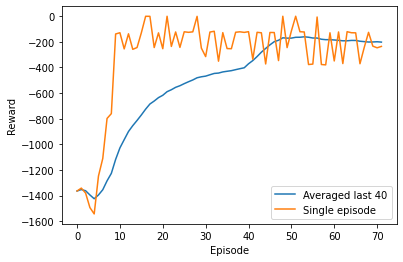

In [34]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.plot(ep_reward_list)
plt.legend(["Averaged last 40", "Single episode"])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

### Playing

In [76]:
play(env2, target_actor, False, -0.005)

Let's play: -2.00, -2.00, -2.00, -2.00, -2.00, -2.00, -2.00, -2.00, -2.00, -2.00, -1.92, -0.18, -1.66, -0.08, -1.99, -1.33, 1.35, -1.92, 1.95, 0.83, -0.99, 1.40, -1.98, 0.41, -1.95, 1.10, -2.00, -0.69, -0.61, -1.03, 0.72, -2.00, -0.76, -0.32, -1.69, 0.99, -1.99, 0.40, -1.98, 0.65, -1.99, 0.15, -1.96, 0.89, -1.99, 0.01, -1.92, 0.92, -1.99, 0.32, -1.97, 0.79, -1.99, -0.10, -1.88, 0.94, -1.98, 0.48, -1.98, 0.53, -1.98, 0.44, -1.98, 0.60, -1.99, 0.29, -1.97, 0.81, -1.99, -0.15, -1.85, 0.95, -1.98, 0.51, -1.98, 0.48, -1.98, 0.53, -1.99, 0.43, -1.98, 0.61, -1.99, 0.26, -1.97, 0.85, -1.99, -0.20, -1.82, 0.95, -1.98, 0.53, -1.98, 0.44, -1.98, 0.60, -1.99, 0.29, -1.97, 0.82, -1.99, -0.15, -1.85, 0.94, -1.98, 0.51, -1.98, 0.48, -1.98, 0.54, -1.99, 0.42, -1.98, 0.63, -1.99, 0.22, -1.97, 0.86, -1.99, -0.13, -1.86, 0.94, -1.98, 0.50, -1.98, 0.49, -1.98, 0.50, -1.98, 0.49, -1.98, 0.51, -1.99, 0.47, -1.98, 0.54, -1.99, 0.41, -1.98, 0.65, -1.99, 0.17, -1.96, 0.88, -1.99, -0.01, -1.91, 0.92, -1.99, 0.3